# Imports

In [24]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import clear_output
from sklearn.svm import LinearSVC as SupportVectorClf
from src.get_data import *
from src.preprocessing import *
from src.create_output import *

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Load data

In [25]:
bd_full = pd.read_csv('data/business.csv')
bd_full['attributes_AgesAllowed'].unique()

array([nan, '21plus', 'allages', '19plus', '18plus'], dtype=object)

In [26]:
b_data, u_data, reviews = get_training_data(verbose=True)
v_queries = get_validation_reviews()

X, y = construct_design_matrix(b_data, u_data, reviews, verbose=True)
X_valid, y_valid = construct_design_matrix(b_data, u_data, v_queries, verbose=True)


b_data.head()

========== Feature 'attributes_AgesAllowed' ==========
TYPE: string. Doing one-hot encoding.

========== Feature 'attributes_GoodForKids' ==========
TYPE: boolean. Changing False -> 0, True -> 1.
Detected NaN in column. Replacing with mean of non-NaN values.

========== Feature 'attributes_OutdoorSeating' ==========
TYPE: boolean. Changing False -> 0, True -> 1.
Detected NaN in column. Replacing with mean of non-NaN values.

========== Feature 'attributes_RestaurantsDelivery' ==========
TYPE: boolean. Changing False -> 0, True -> 1.
Detected NaN in column. Replacing with mean of non-NaN values.

========== Feature 'attributes_RestaurantsGoodForGroups' ==========
TYPE: boolean. Changing False -> 0, True -> 1.
Detected NaN in column. Replacing with mean of non-NaN values.

========== Feature 'attributes_RestaurantsPriceRange2' ==========
TYPE: numeric.
Detected NaN in column. Replacing with mean of non-NaN values.

========== Feature 'attributes_RestaurantsReservations' ==========
TYPE: 

NameError: name 'queries' is not defined

In [28]:
X_test = construct_test_matrix(b_data, u_data, verbose=True)

Constructing test feature-matrix now.
0/50078 done
10000/50078 done
20000/50078 done
30000/50078 done
40000/50078 done
50000/50078 done
Finished!


# Preprocessing / dimensionality reduction

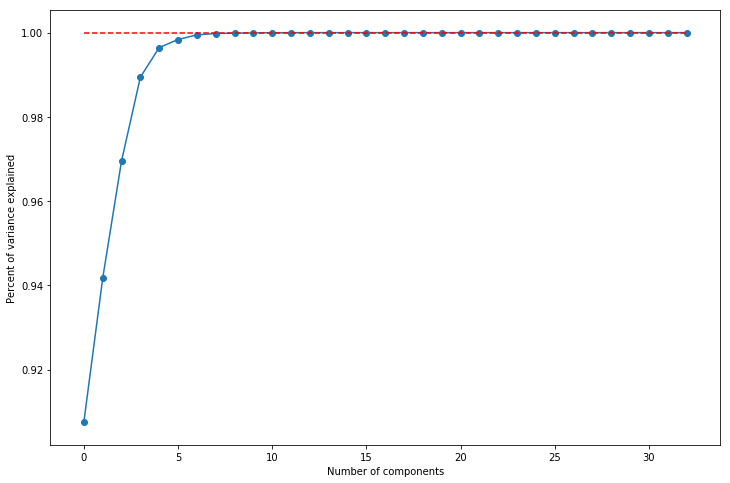

Using 10 components - 0.999978 of variance explained.


In [29]:
X_n = normalize_columns(X)
X_valid_n = normalize_columns(X_valid)

Z = get_PCA_matrix(X, n_components=10, plot_expl_variance=True, verbose=True)
X_pca = np.dot(X, Z.T)
X_valid_pca = np.dot(X_valid, Z.T)

# Hyperparameter Tuning

In [32]:
results = dict()

def rmse(y1, y2):
    return np.sqrt(np.mean((y1-y2)**2))

In [ ]:
min_validation_mse = (float('inf'), 0.1)
for penalty_constant in [0.1, 0.25, 0.5, 0.75, 1.0, 1.5, 2.0, 3.0, 8.0]:
    clf = SupportVectorClf(penalty='l2', 
                           loss='squared_hinge', 
                           dual=False, 
                           C=penalty_constant,
                           max_iter=4000)
    clf.fit(X, y)

    # training error
    y_pred_train = clf.predict(X)
    mse_train = rmse(y, y_pred_train)
    print('{}  <- Training RMSE with C={}'.format(mse_train, penalty_constant))

    print('')

    # validation error
    y_pred_valid = clf.predict(X_valid)
    mse_valid = rmse(y_valid, y_pred_valid)
    print('{}  <- Validation RMSE with C={}'.format(mse_valid, penalty_constant))
    if mse_valid < min_validation_mse[0]:
        min_validation_mse = (mse_valid, penalty_constant)
opt_penalty = min_validation_mse[1]
print("Optimal penalty constant of {} found".format(opt_penalty))

1.232646192385958  <- Training RMSE with C=0.1

1.2763898607173771  <- Validation RMSE with C=0.1
1.2283239613312564  <- Training RMSE with C=0.25

1.2724097999008492  <- Validation RMSE with C=0.25
1.237924257509533  <- Training RMSE with C=0.5

1.2754351525515983  <- Validation RMSE with C=0.5


# Test data output

In [ ]:
clf = SupportVectorClf(penalty='l2', 
                       loss='squared_hinge', 
                       dual=False, 
                       C=opt_penalty,
                       max_iter=15000)
clf.fit(X, y)
y_test = clf.predict(X_test)
y_cleaned = format_output(y_test)
write_output(y_cleaned)

# Normalized/PCA'd Calculations

In [21]:
# Do calculations with normalized columns
clf_n = SupportVectorClf(penalty='l2', 
                       loss='squared_hinge', 
                       dual=False, 
                       C=opt_penalty,
                       max_iter=4000)
clf_n.fit(X_n, y)

# training error (normalized columns)
y_pred_train_norm = clf_n.predict(X_n)
mse_train_norm = rmse(y, y_pred_train_norm)
print('%f  <- Training RMSE (norm)' % mse_train_norm)

# validation error (normalized columns)
y_pred_valid_norm = clf_n.predict(X_valid_n)
mse_valid_norm = rmse(y_valid, y_pred_valid_norm)
print('%f  <- Validation RMSE (norm)' % mse_valid_norm)

1.208944  <- Training RMSE (norm)
1.238514  <- Validation RMSE (norm)


In [22]:
clf_pca = SupportVectorClf(penalty='l2', 
                       loss='squared_hinge', 
                       dual=False, 
                       C=opt_penalty,
                       max_iter=4000)
clf_pca.fit(X_pca, y)

# training error (PCA)
y_pred_train_pca = clf_pca.predict(X_pca)
mse_train_pca = rmse(y, y_pred_train_pca)
print('%f  <- Training RMSE (PCA)' % mse_train_pca)


# validation error (PCA)
y_pred_valid_pca = clf_pca.predict(X_valid_pca)
mse_valid_pca = rmse(y_valid, y_pred_valid_pca)
print('%f  <- Validation RMSE (PCA)' % mse_valid_pca)

1.403593  <- Training RMSE (PCA)
1.549523  <- Validation RMSE (PCA)


# Inspect weight vector

num weights ~= 0: 50


ValueError: x and y must be the same size

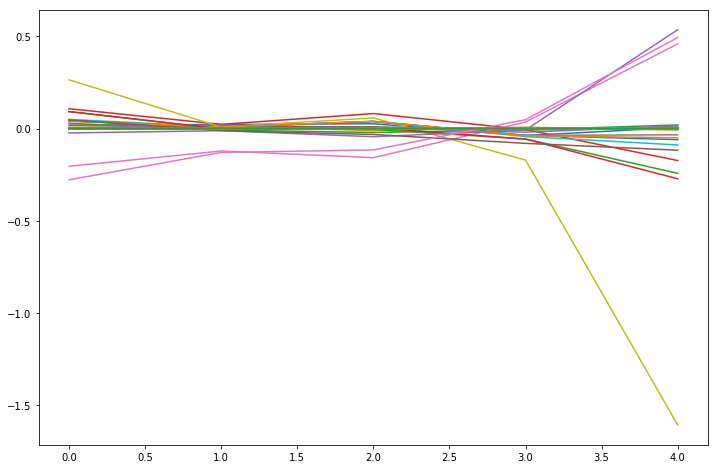

In [23]:
w = clf.coef_
xs = range(len(w))

tiny_weights = np.argwhere(abs(w) <= 10**-4)
print('num weights ~= 0: %d' % len(tiny_weights))


f, ax = plt.subplots(figsize=(12, 8))
ax.plot(xs, w)
ax.scatter(xs, w)
ax.scatter(tiny_weights, w[tiny_weights], color='red', zorder=5, label='|w| < 10**-4')
plt.legend()
plt.show()

In [ ]:
all_columns = np.append(b_data.columns, u_data.columns)

for i, col in enumerate(all_columns):
    if w[i] < 0:
        print('%f  <- |w| for %s' % (w[i], col))
    else:
        print(' %f  <- |w| for %s' % (w[i], col))